In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

## Import the Data

In [2]:
df = pd.read_csv("./data/DF_Daily_Time_Series.csv")
df.reset_index(drop=True)

,date,position,title,artist,spotify_id,is_new,last_pos,peak_pos,weeks,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,month_year
0,1990-01-06,1,Another Day In Paradise,Phil Collins,1NCuYqMc8hKMb4cpNTcJbD,False,1,1,10,0.780,...,0.272727,0.754311,0,0.0306,0.7360,0.002690,0.0630,0.365,0.322684,1990-01
1,1990-01-06,2,Rhythm Nation,Janet Jackson,4nTYxxF8iWBq54LO3dBUie,False,4,2,9,0.633,...,0.090909,0.740149,1,0.0686,0.0504,0.109000,0.3750,0.676,0.366006,1990-01
2,1990-01-06,3,Don't Know Much,Linda Ronstadt (Featuring Aaron Neville),35iKfvnDtZezUzd8NlcfGe,False,2,2,15,0.719,...,1.000000,0.474726,1,0.0404,0.3350,0.537000,0.0638,0.272,0.479302,1990-01
3,1990-01-06,4,Pump Up The Jam,Technotronic Featuring Felly,21qnJAMtzC6S5SESuqQLEK,False,7,4,13,0.885,...,0.909091,0.691864,0,0.0733,0.0147,0.000004,0.0494,0.715,0.459850,1990-01
4,1990-01-06,5,With Every Beat Of My Heart,Taylor Dayne,3hK26G5cYhJ9KjcUy1aBRk,False,5,5,12,0.773,...,0.454545,0.837966,1,0.0340,0.0827,0.000002,0.0984,0.971,0.440264,1990-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159032,2021-02-13,96,Fake Woke,Tom MacDonald,22N2WWWq3pGweYgP5o5q7w,True,0,96,1,0.661,...,0.727273,0.771193,1,0.1330,0.0971,0.000000,0.1270,0.158,0.249802,2021-02
159033,2021-02-13,97,Prisoner,Miley Cyrus Featuring Dua Lipa,22N2WWWq3pGweYgP5o5q7w,False,81,54,11,0.781,...,0.272727,0.866026,0,0.0452,0.0103,0.000000,0.0761,0.595,0.480381,2021-02
159034,2021-02-13,98,Dangerous,Morgan Wallen,22N2WWWq3pGweYgP5o5q7w,False,0,62,3,0.635,...,0.636364,0.836098,1,0.0279,0.2160,0.000000,0.2850,0.948,0.426005,2021-02
159035,2021-02-13,99,Almost Maybes,Jordan Davis,22N2WWWq3pGweYgP5o5q7w,False,0,95,2,0.582,...,1.000000,0.865535,1,0.0522,0.1460,0.000000,0.1030,0.555,0.250801,2021-02


### We will take all the best songs per months and aggregate them to find each month's mean features

We dropped string values and 2 features key and instrumentalness. In the clustering and classification models, we noticed that these features won't contribute to the model, so we will drop them before starting to work on the time series model.

In [3]:
fixed_df = df.drop(columns=["title", "artist","spotify_id","is_new","last_pos","position","key","instrumentalness"])

We want to aggregate the top songs of each month. Our hypothesis is that there is a similarity in features in successful song so we would like to predict which features will be used in successful songs in the future. We measure song success by its peak position and by the number of appearences the song made in different weeks.

In [4]:
fixed_df = fixed_df.loc[fixed_df["peak_pos"] < 25]
fixed_df = fixed_df.loc[fixed_df["weeks"] > 5].groupby('month_year').mean()
fixed_df = fixed_df.drop(columns=["peak_pos", "weeks"])

In [5]:
fixed_df

,danceability,energy,loudness,mode,speechiness,acousticness,liveness,valence,tempo
month_year,,,,,,,,,
1990-01,0.630260,0.665077,0.688201,0.650888,0.055056,0.165226,0.162822,0.586083,0.412984
1990-02,0.645926,0.666276,0.692767,0.736196,0.057111,0.163809,0.171035,0.597663,0.417995
1990-03,0.650222,0.652237,0.682651,0.762887,0.056255,0.161965,0.159654,0.571773,0.406299
1990-04,0.630709,0.669716,0.690572,0.738806,0.053413,0.159603,0.158996,0.600575,0.430845
1990-05,0.637906,0.661852,0.696228,0.710938,0.060371,0.174774,0.172884,0.600820,0.407230
...,...,...,...,...,...,...,...,...,...
2020-10,0.694059,0.653637,0.790261,0.495098,0.130855,0.173218,0.172858,0.480221,0.459309
2020-11,0.686750,0.667058,0.792962,0.448718,0.134620,0.173840,0.174962,0.483581,0.472702
2020-12,0.650519,0.595080,0.745870,0.549383,0.103267,0.320473,0.167510,0.573328,0.458979


In [6]:
test = fixed_df.copy()

## Visualize the Time Series
We wanted to see how each feature acts through the years

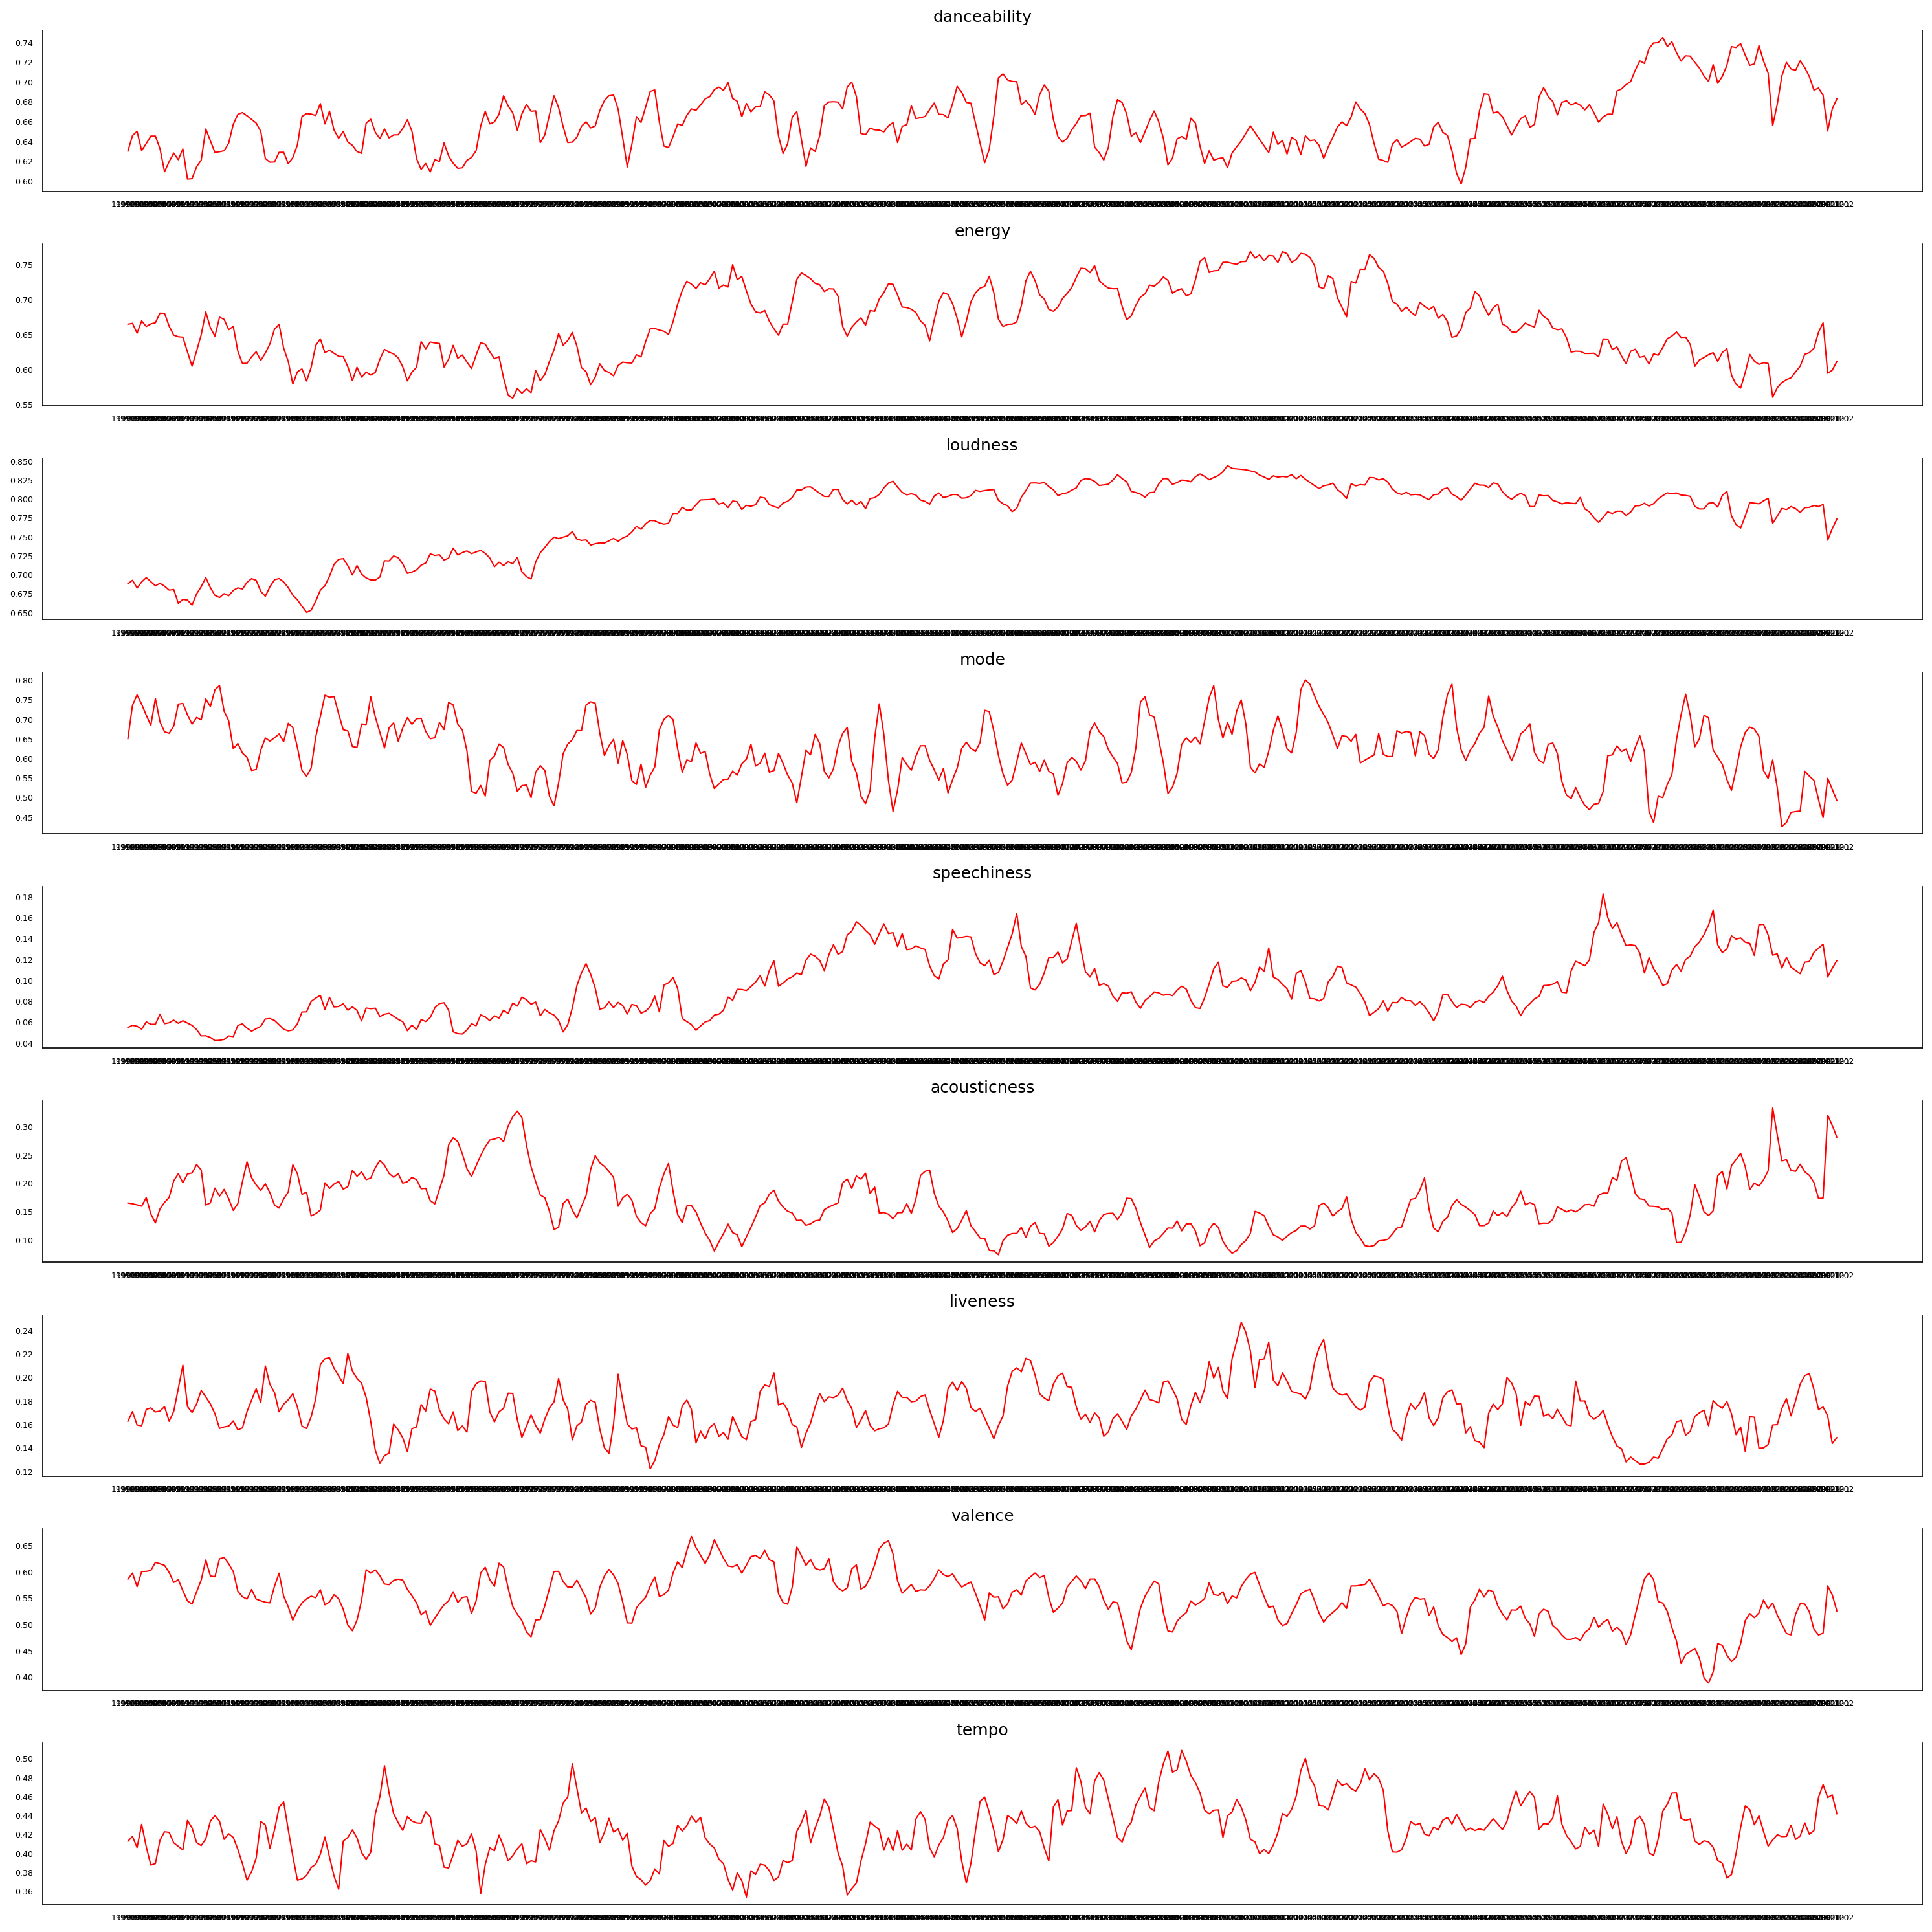

In [7]:
# Plot
fig, axes = plt.subplots(nrows=int(len(test.columns)), ncols=1, dpi=150, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    data = test[test.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(test.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout();

## Split the data to test and train sets
We decided to take 3 steps as our test set. Each step represent a month, therefore we will try to forcast how the features will look like for the next quarter of the year. We will be using VAR model for this time series. VAR models are used when we got features that affect each other. As we already familiar with the data, we know that feature might impact each other.

In [8]:
nobs = 3
df_train, df_test = test[0:-nobs], test[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(371, 9)
(3, 9)


## Check for Stationarity and Make the Time Series Stationary

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity - The mean and standard deviation don't change.

A stationary time series is one whose characteristics like mean and variance does not change over time.

In [9]:
def adjust(val, length= 6): return str(val).ljust(length)
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [10]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "danceability" 
    -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -2.5508
 No. Lags Chosen       = 7
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.1036. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "energy" 
    -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -1.8893
 No. Lags Chosen       = 7
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.3371. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "loudness" 
    -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -1.7681
 No. Lags Chosen       = 7
 Critical value 1%     = -3.448
 Critica

#### The ADF test confirms that we have features that are non stationary - "energy",  "loudness", "speechiness", "valence" and "duration". 

If a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.

In [11]:
df_differenced = df_train.diff().dropna()

In [12]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "danceability" 
    -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -10.7329
 No. Lags Chosen       = 6
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "energy" 
    -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -10.1083
 No. Lags Chosen       = 6
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "loudness" 
    -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -10.2159
 No. Lags Chosen       = 6
 Critical value 1%     = -3.448
 Critical value 5%     = -2.87
 Critical value 10%    =

#### All the series are now stationary. Let’s prepare the training and test datasets.

## Select the Order (P) of VAR model
To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.
 AIC basically quantifies:
<br>
1) The goodness of fit
<br>
2) The simplicity of the model into a single statistic.

In [13]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic, '\n')

Lag Order = 1
AIC :  -76.46902621097446 

Lag Order = 2
AIC :  -76.37245930788207 

Lag Order = 3
AIC :  -76.5740549614637 

Lag Order = 4
AIC :  -76.56602524077853 

Lag Order = 5
AIC :  -76.44455491409126 

Lag Order = 6
AIC :  -76.21199949580321 

Lag Order = 7
AIC :  -76.06629979873156 

Lag Order = 8
AIC :  -75.90868163258567 

Lag Order = 9
AIC :  -75.77124651599377 

Lag Order = 10
AIC :  -75.6474440114769 

Lag Order = 11
AIC :  -75.63339592184894 

Lag Order = 12
AIC :  -75.54237848244868 



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### The optimal lag is observed at a lag order of 3, so we will select it.

In [14]:
model_fitted = model.fit(3)

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
Checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.
<br>
The closer it is to the value 2, then there is no significant serial correlation.

In [15]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

date   : 2.03
position : 2.0
title  : 2.05
artist : 2.07
spotify_id : 2.01
is_new : 2.09
last_pos : 2.03
peak_pos : 1.98
weeks  : 2.01


#### We can see that all parameters are close to the value of 2, so there is no significant serial correlation.

## Forecast VAR model using statsmodels
#### Get the lag order

In [16]:
lag_order = model_fitted.k_ar
print(lag_order) 

3


#### Input data for forecasting

In [17]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[-0.01362179,  0.00632846,  0.00234373, -0.0106095 ,  0.00883556,
        -0.01240212, -0.0133332 , -0.03331154,  0.00387739],
       [ 0.0020968 ,  0.02291574, -0.00128589, -0.04920576,  0.00394478,
        -0.02839714, -0.01707254, -0.01078637,  0.03511967],
       [-0.00730882,  0.01342044,  0.00270026, -0.04638009,  0.00376497,
         0.00062177,  0.0021037 ,  0.00336018,  0.01339369]])

### Forecast

In [18]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=test.index[-nobs:], columns=test.columns + '_1d')
df_forecast

,danceability_1d,energy_1d,loudness_1d,mode_1d,speechiness_1d,acousticness_1d,liveness_1d,valence_1d,tempo_1d
month_year,,,,,,,,,
2020-12,-0.001850,-0.000492,0.000615,0.024053,-0.002688,0.003068,0.006284,0.008588,0.001613
2021-01,-0.000439,0.003081,0.004815,0.054147,0.000893,-0.003067,0.006460,0.010582,-0.005091
2021-02,0.001976,-0.000989,0.002139,0.024593,0.001398,-0.004041,0.000896,0.003666,-0.000958


### Invert the transformation to get the real forecast

In [19]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [20]:
df_results = invert_transformation(df_train, df_forecast)        

The forecasts are back to the original scale. Let’s plot the forecasts against the actuals from test data.

In [21]:
df_results

,danceability_1d,energy_1d,loudness_1d,mode_1d,speechiness_1d,acousticness_1d,liveness_1d,valence_1d,tempo_1d,danceability_forecast,energy_forecast,loudness_forecast,mode_forecast,speechiness_forecast,acousticness_forecast,liveness_forecast,valence_forecast,tempo_forecast
month_year,,,,,,,,,,,,,,,,,,
2020-12,-0.001850,-0.000492,0.000615,0.024053,-0.002688,0.003068,0.006284,0.008588,0.001613,0.684900,0.666566,0.793577,0.472771,0.131932,0.176908,0.181246,0.492169,0.474315
2021-01,-0.000439,0.003081,0.004815,0.054147,0.000893,-0.003067,0.006460,0.010582,-0.005091,0.684461,0.669647,0.798392,0.526918,0.132825,0.173841,0.187706,0.502751,0.469224
2021-02,0.001976,-0.000989,0.002139,0.024593,0.001398,-0.004041,0.000896,0.003666,-0.000958,0.686436,0.668657,0.800530,0.551511,0.134223,0.169800,0.188601,0.506416,0.468266


In [22]:
df_results.columns

Index(['danceability_1d', 'energy_1d', 'loudness_1d', 'mode_1d',
       'speechiness_1d', 'acousticness_1d', 'liveness_1d', 'valence_1d',
       'tempo_1d', 'danceability_forecast', 'energy_forecast',
       'loudness_forecast', 'mode_forecast', 'speechiness_forecast',
       'acousticness_forecast', 'liveness_forecast', 'valence_forecast',
       'tempo_forecast'],
      dtype='object')

In [23]:
df_results.loc[:, [ 'danceability_forecast', 'energy_forecast', 'loudness_forecast',
       'mode_forecast', 'speechiness_forecast', 'acousticness_forecast',
       'liveness_forecast', 'valence_forecast', 'tempo_forecast']]

,danceability_forecast,energy_forecast,loudness_forecast,mode_forecast,speechiness_forecast,acousticness_forecast,liveness_forecast,valence_forecast,tempo_forecast
month_year,,,,,,,,,
2020-12,0.684900,0.666566,0.793577,0.472771,0.131932,0.176908,0.181246,0.492169,0.474315
2021-01,0.684461,0.669647,0.798392,0.526918,0.132825,0.173841,0.187706,0.502751,0.469224
2021-02,0.686436,0.668657,0.800530,0.551511,0.134223,0.169800,0.188601,0.506416,0.468266


In [24]:
df_test[-nobs:]

,danceability,energy,loudness,mode,speechiness,acousticness,liveness,valence,tempo
month_year,,,,,,,,,
2020-12,0.650519,0.595080,0.745870,0.549383,0.103267,0.320473,0.167510,0.573328,0.458979
2021-01,0.672920,0.599441,0.760942,0.521277,0.111684,0.302343,0.143945,0.556306,0.461896
2021-02,0.683030,0.611791,0.773716,0.492537,0.118903,0.281510,0.148919,0.525915,0.441954


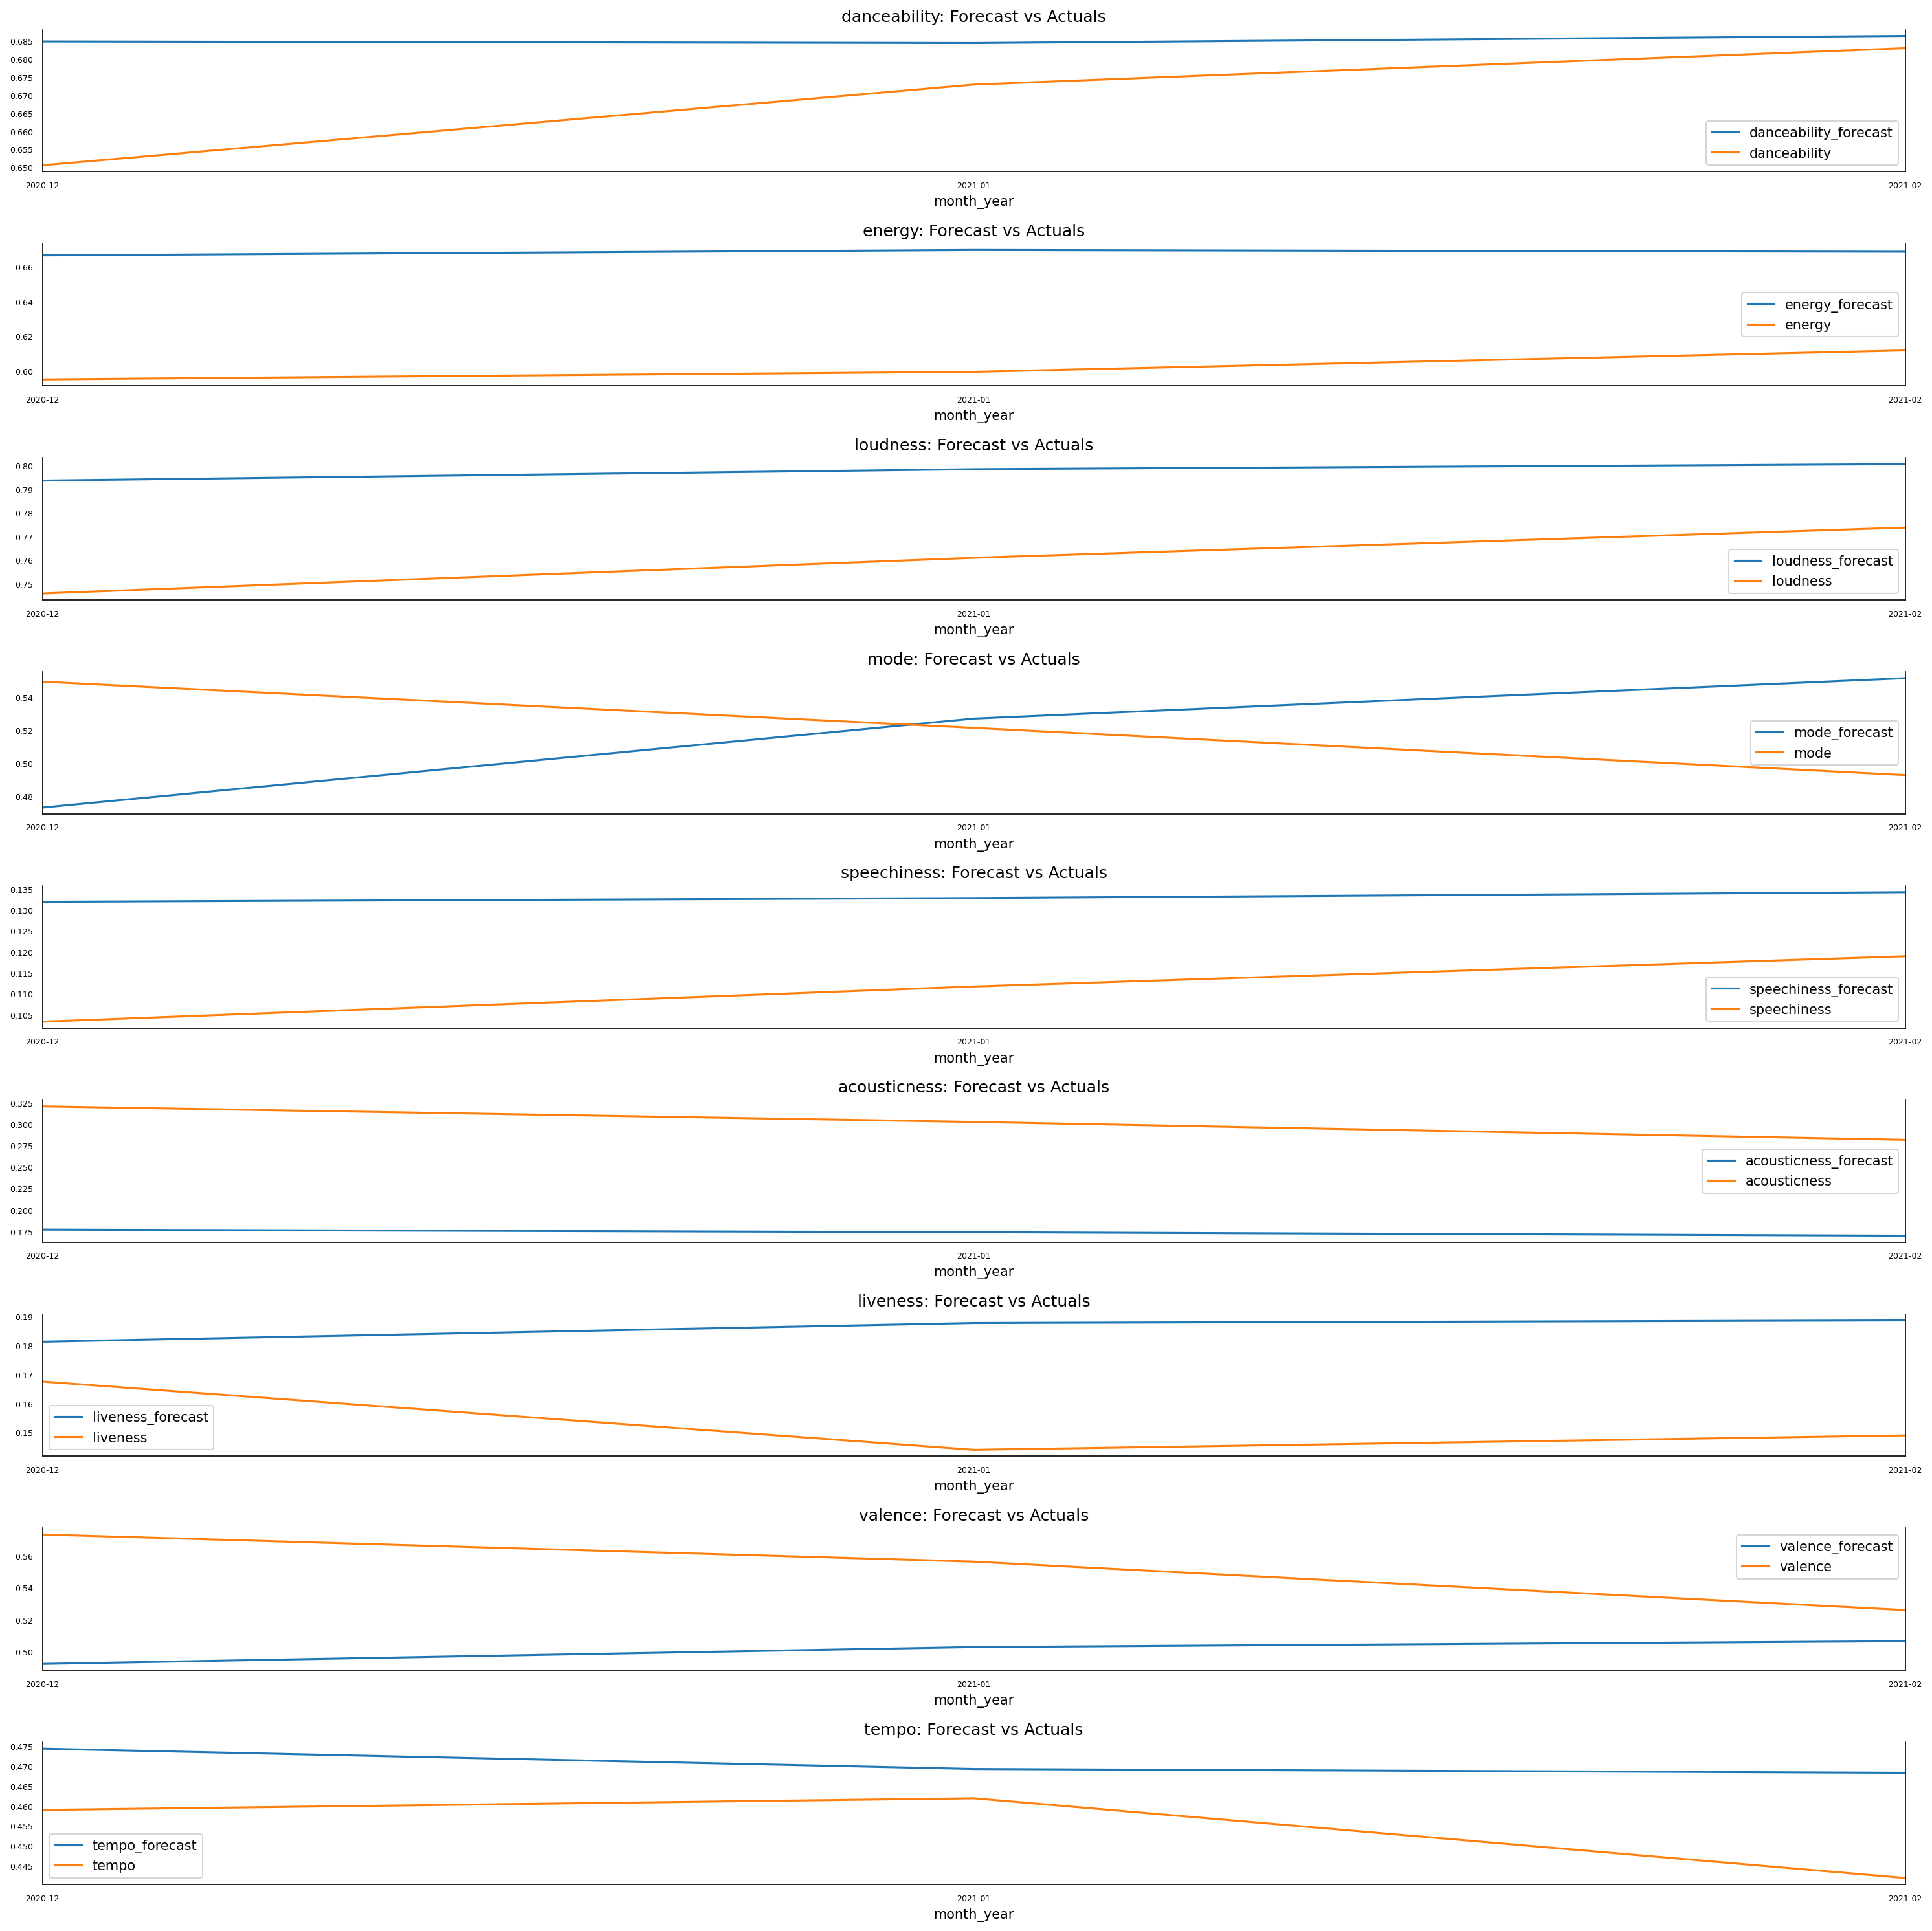

In [25]:
fig, axes = plt.subplots(nrows=int(len(test.columns)/1), ncols=1, dpi=150, figsize=(20,20))
for i, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [26]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'rmse':rmse, 'corr':corr})


print('\nForecast Accuracy of: danceability')
accuracy_prod = forecast_accuracy(df_results['danceability_forecast'].values, df_test['danceability'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: energy')
accuracy_prod = forecast_accuracy(df_results['energy_forecast'].values, df_test['energy'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: loudness')
accuracy_prod = forecast_accuracy(df_results['loudness_forecast'].values, df_test['loudness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: mode')
accuracy_prod = forecast_accuracy(df_results['mode_forecast'].values, df_test['mode'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: speechiness')
accuracy_prod = forecast_accuracy(df_results['speechiness_forecast'].values, df_test['speechiness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: acousticness')
accuracy_prod = forecast_accuracy(df_results['acousticness_forecast'].values, df_test['acousticness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: liveness')
accuracy_prod = forecast_accuracy(df_results['liveness_forecast'].values, df_test['liveness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: valence')
accuracy_prod = forecast_accuracy(df_results['valence_forecast'].values, df_test['valence'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))    

    
print('\nForecast Accuracy of: tempo')
accuracy_prod = forecast_accuracy(df_results['tempo_forecast'].values, df_test['tempo'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: danceability
rmse   :  0.021
corr   :  0.5804

Forecast Accuracy of: energy
rmse   :  0.0665
corr   :  0.4422

Forecast Accuracy of: loudness
rmse   :  0.0383
corr   :  0.9854

Forecast Accuracy of: mode
rmse   :  0.0559
corr   :  -0.9759

Forecast Accuracy of: speechiness
rmse   :  0.0224
corr   :  0.9854

Forecast Accuracy of: acousticness
rmse   :  0.1286
corr   :  0.9992

Forecast Accuracy of: liveness
rmse   :  0.035
corr   :  -0.9513

Forecast Accuracy of: valence
rmse   :  0.0573
corr   :  -0.907

Forecast Accuracy of: tempo
rmse   :  0.0181
corr   :  0.5104


### We noticed that songs might be affected by the time of the year. Good example is Christmas songs in December and Latin songs in summer time. The VAR model has no seasonality component in it, so we decided to try and create a forcast for the next year using 12 lag, which means our next year forcast will be based on last year's data.

In [27]:
nobs = 12
df_train, df_test = test[0:-nobs], test[-nobs:]
model_fitted = model.fit(12)
lag_order = model_fitted.k_ar
forecast_input = df_differenced.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=test.index[-nobs:], columns=test.columns + '_1d')
df_results = invert_transformation(df_train, df_forecast) 

In [28]:
df_results.loc[:, [ 'danceability_forecast', 'energy_forecast', 'loudness_forecast',
       'mode_forecast', 'speechiness_forecast', 'acousticness_forecast',
       'liveness_forecast', 'valence_forecast', 'tempo_forecast']]

,danceability_forecast,energy_forecast,loudness_forecast,mode_forecast,speechiness_forecast,acousticness_forecast,liveness_forecast,valence_forecast,tempo_forecast
month_year,,,,,,,,,
2020-03,0.708889,0.567478,0.783230,0.460504,0.101275,0.243850,0.190770,0.513542,0.390220
2020-04,0.716603,0.562042,0.786801,0.516084,0.109638,0.259061,0.196533,0.513532,0.374689
2020-05,0.720826,0.548519,0.790787,0.561369,0.117495,0.268938,0.186104,0.509239,0.387262
2020-06,0.732475,0.534057,0.785752,0.542922,0.115729,0.283304,0.174310,0.497179,0.373831
2020-07,0.744523,0.533085,0.783947,0.489189,0.114362,0.293634,0.170848,0.502473,0.363898
2020-08,0.744543,0.530873,0.780870,0.455805,0.106579,0.302663,0.177423,0.521284,0.363188
2020-09,0.736784,0.536742,0.782645,0.436436,0.104221,0.294460,0.185813,0.523422,0.356644
2020-10,0.735570,0.541270,0.785658,0.443741,0.107495,0.287330,0.196589,0.517532,0.360019
2020-11,0.728794,0.537998,0.786521,0.473979,0.109343,0.286063,0.198756,0.513487,0.364853


In [29]:
df_test[-nobs:]

,danceability,energy,loudness,mode,speechiness,acousticness,liveness,valence,tempo
month_year,,,,,,,,,
2020-03,0.720040,0.585952,0.786204,0.436508,0.122094,0.241831,0.182086,0.482918,0.418135
2020-04,0.713379,0.588606,0.790207,0.462121,0.112742,0.222688,0.167433,0.480430,0.429894
2020-05,0.712024,0.596988,0.787428,0.464286,0.109668,0.221089,0.180335,0.519658,0.414901
2020-06,0.721603,0.605192,0.782348,0.465753,0.106427,0.233855,0.194365,0.539516,0.418487
2020-07,0.714809,0.622170,0.788711,0.567376,0.117436,0.220396,0.201725,0.538935,0.432343
2020-08,0.705584,0.624393,0.789204,0.554913,0.118075,0.214018,0.203264,0.524318,0.420312
2020-09,0.691962,0.630722,0.791547,0.544304,0.126910,0.201616,0.189930,0.491007,0.424189
2020-10,0.694059,0.653637,0.790261,0.495098,0.130855,0.173218,0.172858,0.480221,0.459309
2020-11,0.686750,0.667058,0.792962,0.448718,0.134620,0.173840,0.174962,0.483581,0.472702


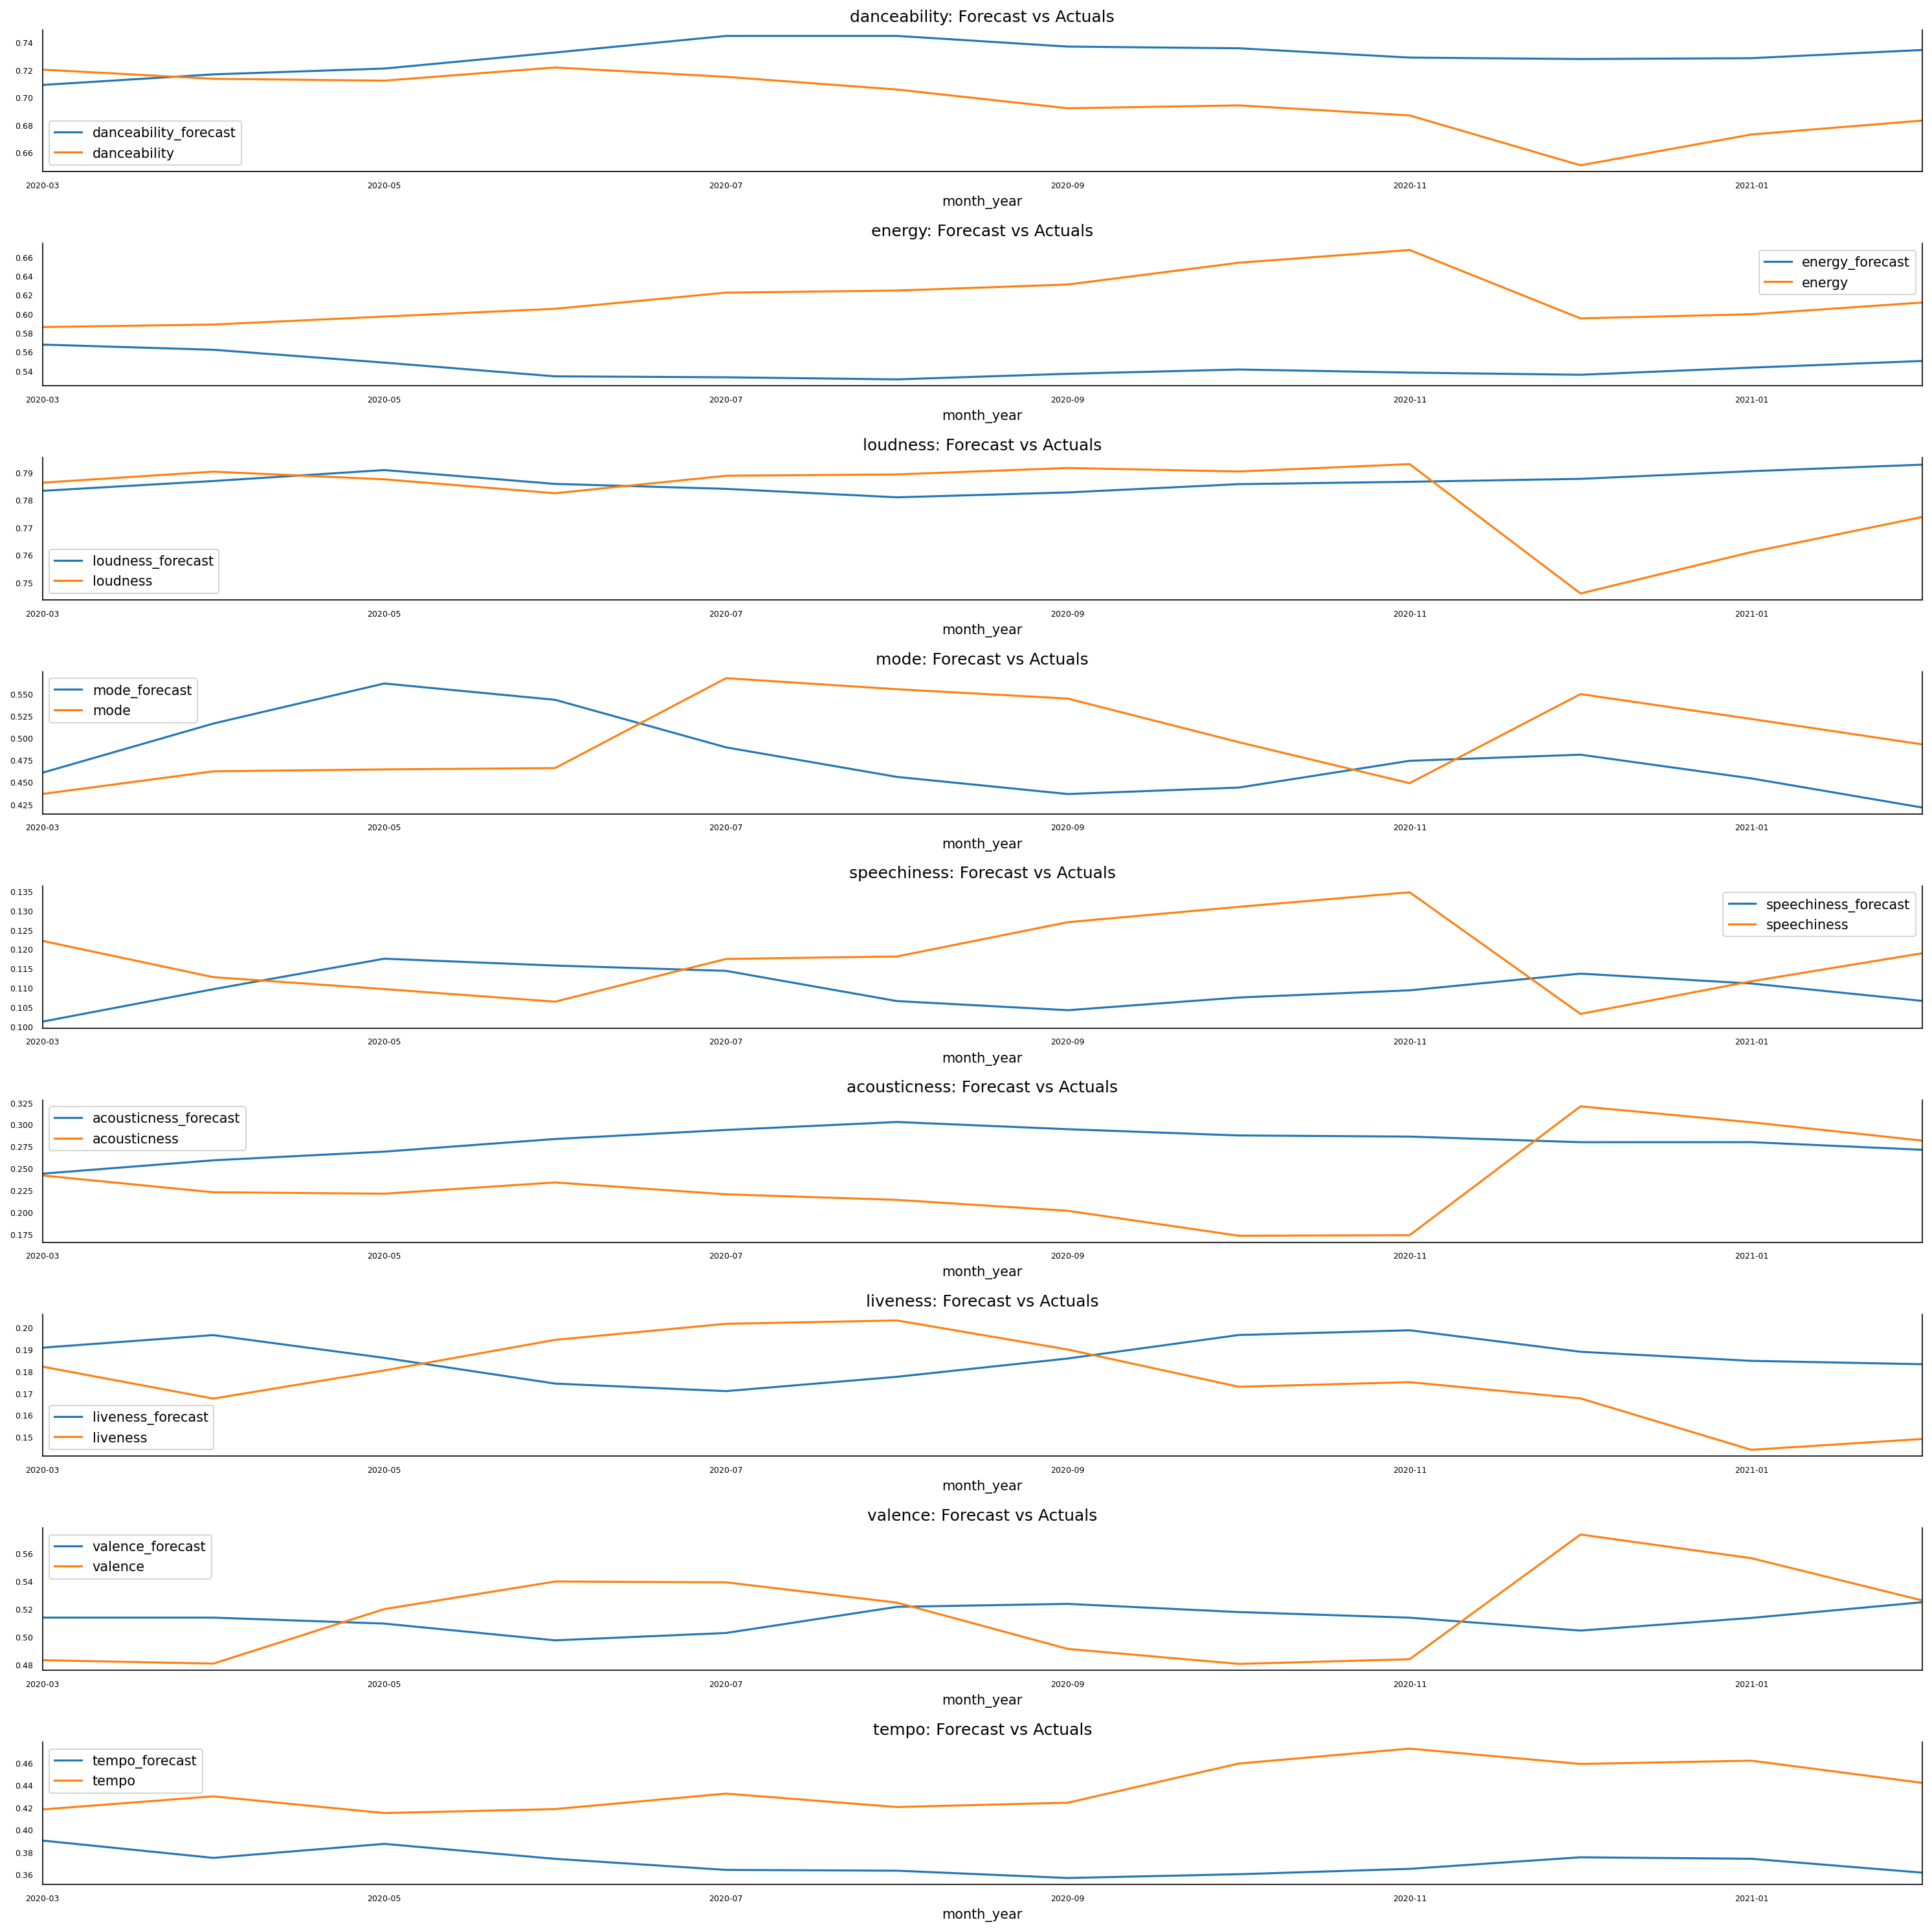

In [30]:
fig, axes = plt.subplots(nrows=int(len(test.columns)/1), ncols=1, dpi=150, figsize=(20,20))
for i, (col,ax) in enumerate(zip(test.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [31]:
print('\nForecast Accuracy of: danceability')
accuracy_prod = forecast_accuracy(df_results['danceability_forecast'].values, df_test['danceability'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: energy')
accuracy_prod = forecast_accuracy(df_results['energy_forecast'].values, df_test['energy'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: loudness')
accuracy_prod = forecast_accuracy(df_results['loudness_forecast'].values, df_test['loudness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: mode')
accuracy_prod = forecast_accuracy(df_results['mode_forecast'].values, df_test['mode'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: speechiness')
accuracy_prod = forecast_accuracy(df_results['speechiness_forecast'].values, df_test['speechiness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: acousticness')
accuracy_prod = forecast_accuracy(df_results['acousticness_forecast'].values, df_test['acousticness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: liveness')
accuracy_prod = forecast_accuracy(df_results['liveness_forecast'].values, df_test['liveness'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: valence')
accuracy_prod = forecast_accuracy(df_results['valence_forecast'].values, df_test['valence'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))    

    
print('\nForecast Accuracy of: tempo')
accuracy_prod = forecast_accuracy(df_results['tempo_forecast'].values, df_test['tempo'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))



Forecast Accuracy of: danceability
rmse   :  0.0407
corr   :  -0.1406

Forecast Accuracy of: energy
rmse   :  0.0784
corr   :  -0.5249

Forecast Accuracy of: loudness
rmse   :  0.0164
corr   :  -0.4643

Forecast Accuracy of: mode
rmse   :  0.073
corr   :  -0.3428

Forecast Accuracy of: speechiness
rmse   :  0.015
corr   :  -0.6262

Forecast Accuracy of: acousticness
rmse   :  0.0682
corr   :  -0.2744

Forecast Accuracy of: liveness
rmse   :  0.0249
corr   :  -0.4679

Forecast Accuracy of: valence
rmse   :  0.0356
corr   :  -0.469

Forecast Accuracy of: tempo
rmse   :  0.0718
corr   :  -0.3324


### There is no obvious choise on what method works better. Some features were predicted better with lag order of 3 and some features were predicted better with lag order of 12.